In [16]:
import sys
sys.path.append('..')

# OS and system
import os
import gc
import argparse
from argparse import Namespace
import pickle

# utils
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time

# mathematics
import matplotlib.pyplot as plt
import numpy as np
import random

# data handling
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision

# logging
# import wandb

# my_lib
from model.net import *
from model.train import train, test
from misc.utils import save_checkpoint, load_transform, load_dataset


In [2]:
random_train_logs = {}
random_test_logs = {}

model_name = 'vcnn_m0'

perturb_eps = [0.0, 0.001, 0.005, 0.01, 0.05]
for eps in perturb_eps:

    # Load the data
    train_temp = []
    test_temp = []
    for seed in range(1, 4):
        train_data = pd.read_csv(f'../results/cifair_nr0.0/{model_name}/PGD_random/eps_{eps}/seed_{seed}/train_log.csv')
        test_data = pd.read_csv(f'../results/cifair_nr0.0/{model_name}/PGD_random/eps_{eps}/seed_{seed}/test_log.csv')

        train_temp.append(train_data)
        test_temp.append(test_data)

    random_train_logs[eps] = train_temp
    random_test_logs[eps] = test_temp



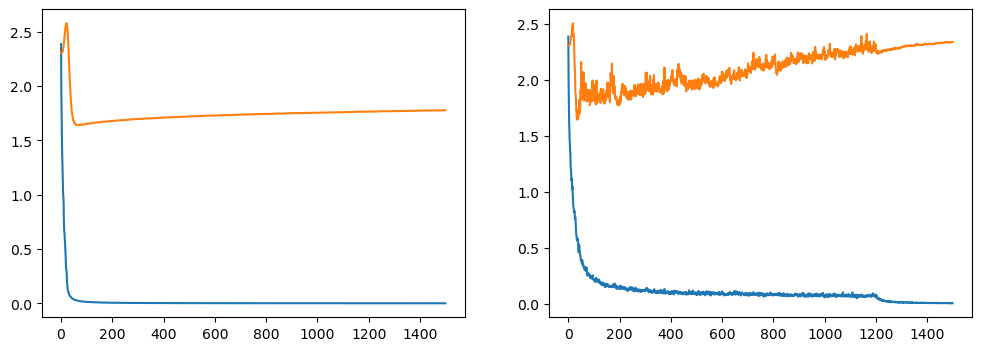

In [136]:
idx = 1
eps = 0.01

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['loss'])
axs[0].plot(random_test_logs[0.0][idx]['loss'])

axs[1].plot(random_train_logs[eps][idx]['loss'])
axs[1].plot(random_test_logs[eps][idx]['loss'])


eps: 0.0 max test acc:  42.989998
eps: 0.005 max test acc:  46.289997


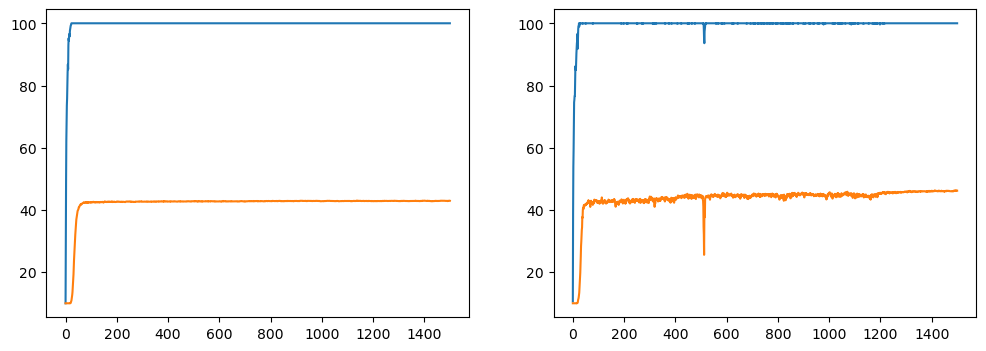

In [114]:
seed = 1
eps = 0.005

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['acc'])
axs[0].plot(random_test_logs[0.0][idx]['acc'])

axs[1].plot(random_train_logs[eps][idx]['acc'])
axs[1].plot(random_test_logs[eps][idx]['acc'])

print('eps: 0.0 max test acc: ', max(random_test_logs[0.0][idx]['acc']))
print(f'eps: {eps} max test acc: ', max(random_test_logs[eps][idx]['acc']))

(40.0, 50.0)

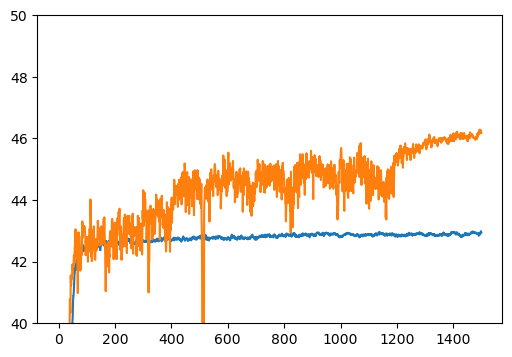

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

eps = 0.005

ax.plot(random_test_logs[0.0][idx]['acc'], label='eps=0.0')
ax.plot(random_test_logs[eps][idx]['acc'], label=f'eps={eps}')

plt.ylim(40, 50)

In [3]:
random_avg_test_accs = {}

for eps in perturb_eps:
    random_avg_test_accs[eps] = []
    for seed in range(3):
        random_avg_test_accs[eps].append(np.mean(random_test_logs[eps][seed]['acc'][-20:]))

Text(0, 0.5, 'avg test acc')

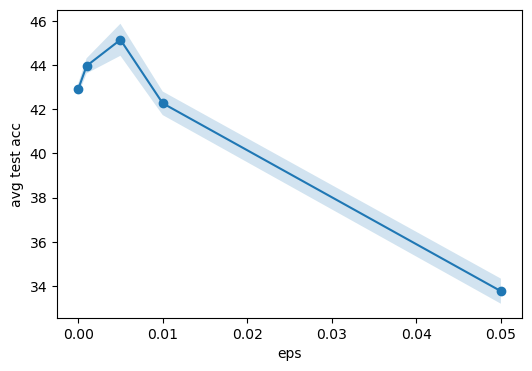

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

perturb_eps = [0.0, 0.001, 0.005, 0.01, 0.05]

x_axis = perturb_eps
y_axis = [np.mean(random_avg_test_accs[eps]) for eps in perturb_eps]
y_axis_std = [np.std(random_avg_test_accs[eps]) for eps in perturb_eps]

ax.plot(x_axis, y_axis, marker='o', label='avg test accs')  
ax.fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), alpha=0.2)
ax.set_xlabel('eps')
ax.set_ylabel('avg test acc')

# ax.set_ylim(42, 48)
# ax.set_xscale('log')

In [5]:
anti_train_logs = {}
anti_test_logs = {}

perturb_eps = [0.003, 0.005, 0.01, 0.03, 0.05]
perturb_taus = [5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 100]

for eps in perturb_eps:
    anti_train_logs[eps] = {}
    anti_test_logs[eps] = {}

    for tau in perturb_taus:
        # Load the data
        train_temp = []
        test_temp = []
        for seed in range(1, 4):
            train_data = pd.read_csv(f'../results/cifair_nr0.0/{model_name}/PGD_anti/eps_{eps}/tau_{tau}/seed_{seed}/train_log.csv')
            test_data = pd.read_csv(f'../results/cifair_nr0.0/{model_name}/PGD_anti/eps_{eps}/tau_{tau}/seed_{seed}/test_log.csv')

            train_temp.append(train_data)
            test_temp.append(test_data)

        anti_train_logs[eps][tau] = train_temp
        anti_test_logs[eps][tau] = test_temp



In [260]:
anti_test_logs[0.003]

{0.05: [      epoch      loss        acc
  0         1  2.302796  10.000000
  1         2  2.302913  10.000000
  2         3  2.303509  10.000000
  3         4  2.304686  10.000000
  4         5  2.306688  10.000000
  ...     ...       ...        ...
  1495   1496  1.833479  43.270000
  1496   1497  1.833507  43.239998
  1497   1498  1.833637  43.250000
  1498   1499  1.833563  43.239998
  1499   1500  1.834004  43.239998
  
  [1500 rows x 3 columns],
        epoch      loss    acc
  0         1  2.302857  10.00
  1         2  2.302816  10.00
  2         3  2.303225  10.00
  3         4  2.304420  10.00
  4         5  2.306922  10.00
  ...     ...       ...    ...
  1495   1496  1.778480  43.87
  1496   1497  1.778515  43.87
  1497   1498  1.778387  43.87
  1498   1499  1.778287  43.89
  1499   1500  1.778172  43.89
  
  [1500 rows x 3 columns],
        epoch      loss        acc
  0         1  2.302845  10.000000
  1         2  2.302824  10.000000
  2         3  2.303186  10.000000
  

(0.0, 4.0)

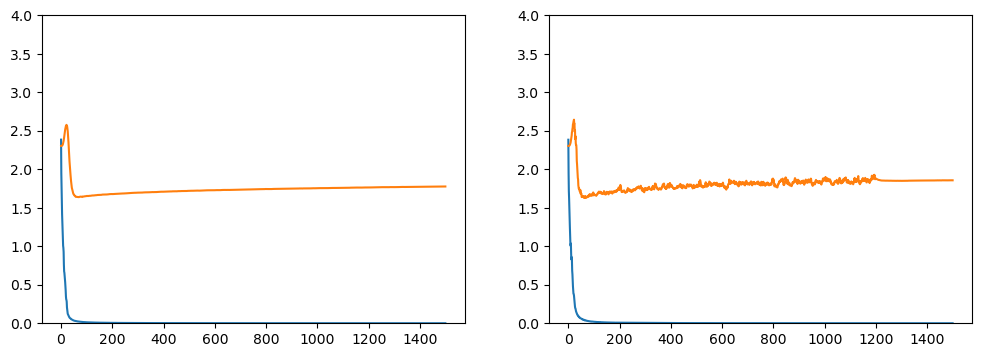

In [125]:
idx = 1
eps = 0.005
tau = 0.5

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['loss'])
axs[0].plot(random_test_logs[0.0][idx]['loss'])

axs[1].plot(anti_train_logs[eps][tau][idx]['loss'])
axs[1].plot(anti_test_logs[eps][tau][idx]['loss'])

axs[0].set_ylim(0, 4)
axs[1].set_ylim(0, 4)


eps: 0.0 max test acc:  42.69
eps: 0.005 max test acc:  43.469997


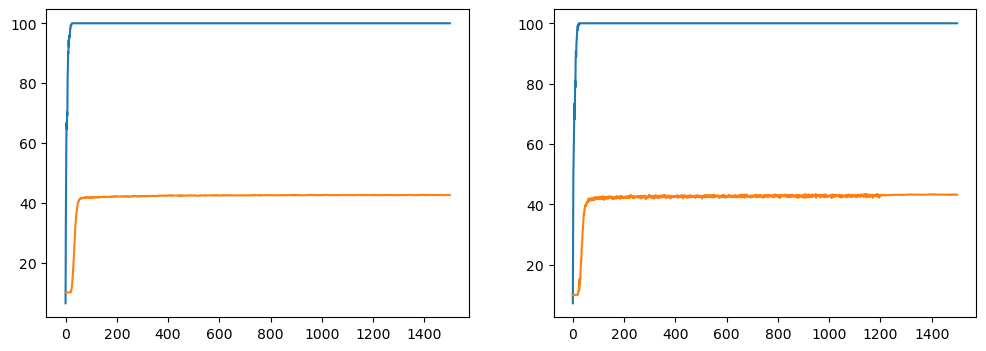

In [54]:
idx = 0
eps = 0.005
tau = 0.05

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['acc'])
axs[0].plot(random_test_logs[0.0][idx]['acc'])

axs[1].plot(anti_train_logs[eps][tau][idx]['acc'])
axs[1].plot(anti_test_logs[eps][tau][idx]['acc'])

print('eps: 0.0 max test acc: ', max(random_test_logs[0.0][idx]['acc']))
print(f'eps: {eps} max test acc: ', max(anti_test_logs[eps][tau][idx]['acc']))

[0.0, 0.001, 0.005, 0.01, 0.05]


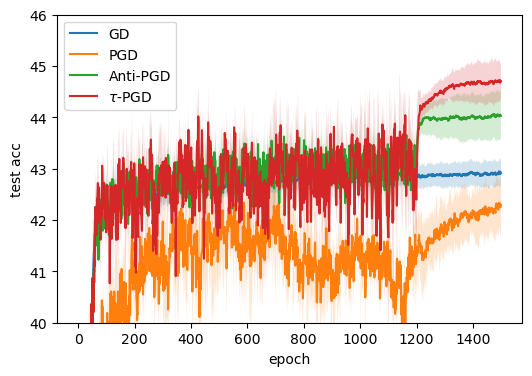

In [134]:
idx = 0
eps = 0.01
tau = 0.05

print(perturb_eps)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

res0 = np.array([random_test_logs[0.0][i]['acc'] for i in range(3)])
res1 = np.array([random_test_logs[eps][i]['acc'] for i in range(3)])
res2 = np.array([anti_test_logs[eps][0.05][i]['acc'] for i in range(3)])
res3 = np.array([anti_test_logs[eps][0.5][i]['acc'] for i in range(3)])


ax.plot(res0.mean(axis=0), label='GD')
ax.fill_between(range(len(res0.mean(axis=0))), res0.mean(axis=0) - res0.std(axis=0), res0.mean(axis=0) + res0.std(axis=0), alpha=0.2)
ax.plot(res1.mean(axis=0), label='PGD')
ax.fill_between(range(len(res1.mean(axis=0))), res1.mean(axis=0) - res1.std(axis=0), res1.mean(axis=0) + res1.std(axis=0), alpha=0.2)
ax.plot(res2.mean(axis=0), label='Anti-PGD')
ax.fill_between(range(len(res2.mean(axis=0))), res2.mean(axis=0) - res2.std(axis=0), res2.mean(axis=0) + res2.std(axis=0), alpha=0.2)
ax.plot(res3.mean(axis=0), label='$\\tau$-PGD')
ax.fill_between(range(len(res3.mean(axis=0))), res3.mean(axis=0) - res3.std(axis=0), res3.mean(axis=0) + res3.std(axis=0), alpha=0.2)

ax.set_ylim(40, 46)
ax.set_xlabel('epoch')
ax.set_ylabel('test acc')
ax.legend()

# ax.plot(random_test_logs[0.0][idx]['acc'])
# ax.plot(random_test_logs[0.05][idx]['acc'])
# ax.plot(anti_test_logs[0.005][tau][idx]['acc'])
# ax.plot(anti_test_logs[0.05][tau][idx]['acc'])


In [7]:
anti_avg_test_accs = {}

for eps in perturb_eps:
    anti_avg_test_accs[eps] = {}
    for tau in perturb_taus:
        anti_avg_test_accs[eps][tau] = []
        for seed in range(3):
            anti_avg_test_accs[eps][tau].append(np.mean(anti_test_logs[eps][tau][seed]['acc'][-20:]))

Text(0.5, 0, '$\\sigma_0$')

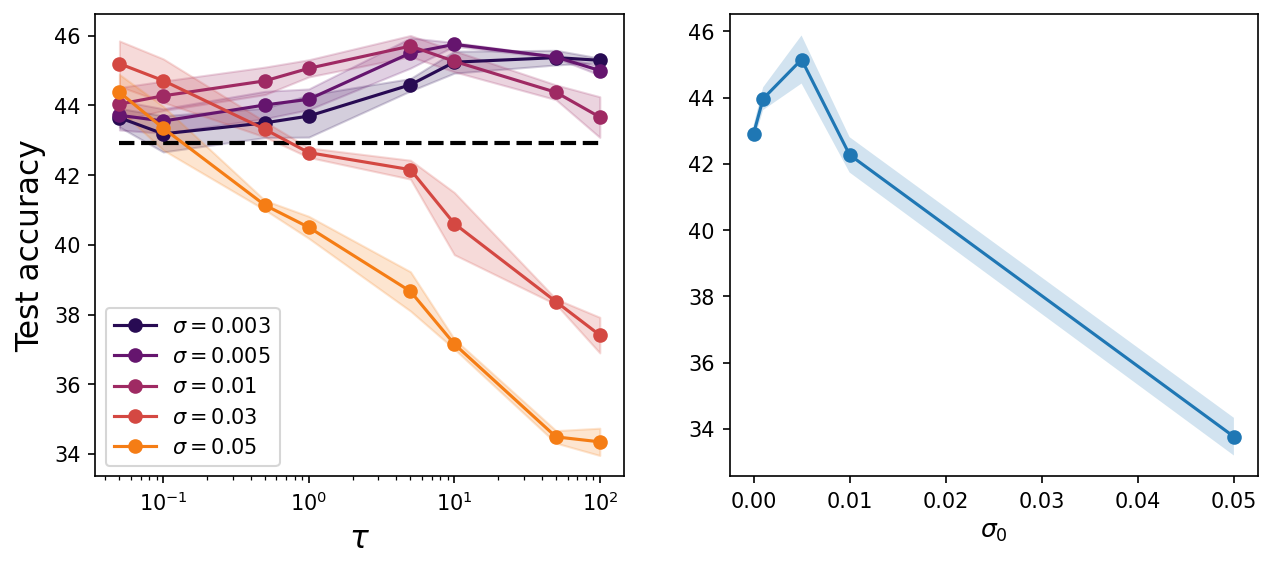

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

x_axis = perturb_taus

axs[0].plot(x_axis, np.mean(random_avg_test_accs[0.0]) * np.ones_like(x_axis), 'k--', lw=2.0)
colors = plt.get_cmap('inferno')(np.linspace(0, 1, len(perturb_eps)+3))
for idx, eps in enumerate([0.003, 0.005, 0.01, 0.03, 0.05]):
    color_idx = idx + 1 # + len(perturb_eps) - 3
    # color_name = 'C' + str(perturb_eps.index(eps))
    # axs[0].plot(x_axis, np.mean(random_avg_test_accs[eps]) * np.ones_like(x_axis), '--', color=color_name, lw=2.0,)

    y_axis = [np.mean(anti_avg_test_accs[eps][tau]) for tau in perturb_taus]
    y_axis_std = [np.std(anti_avg_test_accs[eps][tau]) for tau in perturb_taus]

    axs[0].plot(x_axis, y_axis, color=colors[color_idx], marker='o', label=f'$\sigma ={eps}$')  
    axs[0].fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), color=colors[color_idx], alpha=0.2)

# axs[0].set_ylim(40, 48)
# axs[1].set_ylim(40, 48)
# axs[0].set_ylim(38, 42)
# ax.set_xscale('log')
axs[0].set_xlabel('$\\tau$', fontsize=15)
axs[0].set_ylabel('Test accuracy', fontsize=15)

axs[0].legend()

axs[0].set_xscale('log')


perturb_eps = [0.0, 0.001, 0.005, 0.01, 0.05]

x_axis = perturb_eps
y_axis = [np.mean(random_avg_test_accs[eps]) for eps in perturb_eps]
y_axis_std = [np.std(random_avg_test_accs[eps]) for eps in perturb_eps]


axs[1].plot(x_axis, y_axis, marker='o')  
axs[1].fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), alpha=0.2)
axs[1].set_xlabel('$\sigma_0$', fontsize=12)
# axs[1].set_xlim(-0.001, 0.03)
# axs[1].set_ylabel('avg test acc', fontsize=12)




In [65]:
from pyhessian import hessian

def trace_hessian(model, criterion, hess_loader, optim, device='cuda'):
    """Compute the Hessian trace of the model with respect to the loss."""
    hess_train = 0.0
    model.eval()
    optim.zero_grad(set_to_none=True)
    for i, data in enumerate(hess_loader):
        inputs, labels = data[0].to(device), data[1].to(device).long()
        hess_trace = np.mean(hessian(model, criterion, data=(inputs, labels), cuda=True).trace())
        hess_train += hess_trace

    hess_train /= len(hess_loader)
    print(f'Hessian trace: {hess_train.item()}')
    return hess_train.item()

In [32]:
args = Namespace()

# args
args.data = 'cifair'
args.path_data = '../data/'
args.num_classes = 10
args.seed = 1
args.trainset_size = 500
args.validset_size = 10000
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model
args.model = 'vcnn'
args.loss_type = 'ce'
args.class_dependent = 0

# dataset
args.split = 0
args.noise_rate = 0.0
args.noisy_valid = False
args.batch_size = 500
args.test_batch_size = 1024
args.num_workers = 4


In [63]:
transforms = load_transform(args)
train_dataset, valid_dataset, test_dataset = load_dataset(transforms, args)
if args.noise_rate > 0:
    print('Corrupting the training set with label noise rate:', args.noise_rate)
print(f"Train dataset size: {len(train_dataset)}, Valid dataset size: {len(valid_dataset)}, Test dataset size: {len(test_dataset)}")

# dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
# validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 500, Valid dataset size: 10000, Test dataset size: 10000


In [ ]:
model_name = 'vcnn_m0'

for s in range(1, 4):
    load_state_dict = torch.load(f'../results/cifair_nr0.0/{model_name}/PGD_random/eps_0.01/seed_{s}/checkpoint.pth.tar', map_location='cpu')
    net = VCNN(args).to(args.device)
    net.load_state_dict(load_state_dict)

    optim = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    trace_hessian(net, nn.CrossEntropyLoss(), trainloader, optim, device=args.device)

35
Hessian trace: 26.233675122261047
6
Hessian trace: 21.891249488381778
20
Hessian trace: 24.753759453936322
7
Hessian trace: 23.197074716741387
22
Hessian trace: 24.02109498977661
